# 0_loader

In [15]:
import torch
from torchvision.datasets import MNIST, FashionMNIST, CelebA
import medmnist
from medmnist import ChestMNIST, PneumoniaMNIST
from torchvision import transforms
from _utils.load_utils import display_from_batch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# params: batch_size
batch_size = 256

# train = FashionMNIST("./_data", train=True, download=True, transform=transforms.ToTensor())
# test = FashionMNIST("./_data", train=False, download=True, transform=transforms.ToTensor())
# classnames = {
#     0:'T-shirt/top',
#     1:'Trouser',
#     2:'Pullover',
#     3:'Dress',
#     4:'Coat',
#     5:'Sandal',
#     6:'Shirt',
#     7:'Sneaker',
#     8:'Bag',
#     9:'Ankle boot',
# }
# train = PneumoniaMNIST(root="./_data", split="train", download=True, transform=transforms.ToTensor())
# test = PneumoniaMNIST(root="./_data", split="test", download=True, transform=transforms.ToTensor())
# classnames={0: 'normal', 1: 'pneumonia'}

# train = ChestMNIST(root="./_data", split="train", download=True, transform=transforms.ToTensor())
# test = ChestMNIST(root="./_data", split="test", download=True, transform=transforms.ToTensor())
# classnames={
#     '0': 'atelectasis', 
#     '1': 'cardiomegaly', 
#     '2': 'effusion', 
#     '3': 'infiltration', 
#     '4': 'mass', 
#     '5': 'nodule', 
#     '6': 'pneumonia', 
#     '7': 'pneumothorax', 
#     '8': 'consolidation', 
#     '9': 'edema', 
#     '10': 'emphysema', 
#     '11': 'fibrosis', 
#     '12': 'pleural', 
#     '13': 'hernia'
# }


train = CelebA(root='./_data', split='train', transform=transforms.Compose([transforms.ToTensor()]), download=True)
test = CelebA(root='./_data', split='test', transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# return train_loader, test_loader

RuntimeError: The daily quota of the file img_align_celeba.zip is exceeded and it can't be downloaded. This is a limitation of Google Drive and can only be overcome by trying again later.

In [2]:
print(train)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./_data
    Split: Train
    StandardTransform
Transform: ToTensor()


# _utils

In [3]:
train_iter = iter(train_loader)

tensor([2, 2, 8, 3])


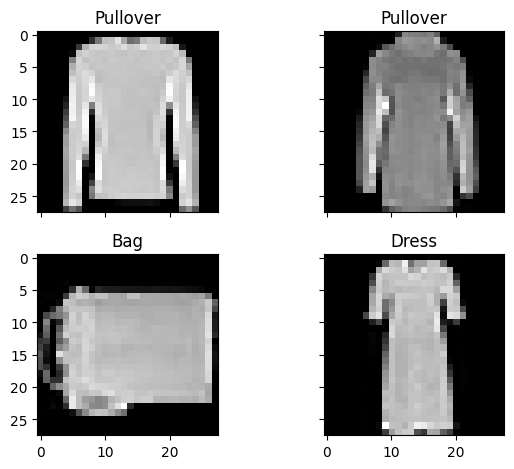

In [4]:
train_batch = next(train_iter)
# params: batch, classname, nrows, ncols
print(train_batch[1][:4])
# print(train_batch[1].squeeze(1))
# print(train_batch[1].squeeze(1).to(torch.long))
# print(train_batch[1].squeeze(1).to(torch.long).dtype)
display_from_batch(train_batch, 2, 2, classnames)

# return none

# 1_model

In [5]:
import torch
from torch import nn, optim

class MyCNN(nn.Module):
    def __init__(self, height, width, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=0)
        self.act1 = nn.ReLU()
        h = (height - 4)
        w = (width - 4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=0)
        self.act2 = nn.ReLU()
        h = (h - 4)
        w = (w - 4)
        self.pool2 = nn.MaxPool2d(2,2)
        h = h / 2
        w = w / 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        self.act3 = nn.ReLU()
        h = (h - 4)
        w = (w - 4)
        self.pool3 = nn.MaxPool2d(2,2)
        h = h / 2
        w = w / 2
        # 3x3 이미지가 됨
        self.fc4 = nn.Linear(64 * int(h) * int(w), 100)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(100, out_features)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        # 모듈화 필요>>>
        sizes = x.size()
        x = x.view(sizes[0], -1)
        # <<<모듈화 필요
        
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        return x


In [6]:
model = MyCNN(height=28, width=28, out_features=10)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list
print('MyCNN: ', sum(numel_list), numel_list)

MyCNN:  123222 [400, 16, 12800, 32, 51200, 64, 57600, 100, 1000, 10]


# 2_train

In [7]:
import torch
from torch import nn, optim
import collections
import tqdm
all_acc_dict = collections.OrderedDict()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import datetime
current_time = datetime.datetime.today() # 2021-08-15 20:58:43.302125
current_time = current_time.strftime('%Y%m%d%H%M%S') # 20210815205827

In [8]:
def eval_net(model, data_loader, device="cpu"):
    model.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        # y = y.squeeze(1).to(torch.long).to(device)
        with torch.no_grad():
            _, y_pred = model(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

In [9]:
n_epochs = 1000

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_losses = []
train_acc = []
val_acc = []
for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    n = 0
    n_acc = 0
    # 시간이 많이 걸리므로 tqdm을 사용해서 진행바를 표시
    for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        xx = xx.to(device)
        yy = yy.to(device)
        # yy = yy.squeeze(1).to(torch.long).to(device)
        h = model(xx)
        loss = loss_fn(h, yy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n += len(xx)
        _, y_pred = h.max(1)
        n_acc += (yy == y_pred).float().sum().item()
    train_losses.append(running_loss / i)
    # 훈련 데이터의 예측 정확도
    train_acc.append(n_acc / n)

    # 검증 데이터의 예측 정확도
    val_acc.append(eval_net(model, test_loader, device))
    print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
print('-----------training finished-----------')
print('train_losses: ', train_losses)
print('train_acc: ', train_acc)
print('val_acc: ', val_acc)

100%|█████████████████████████████████████████| 234/234 [00:07<00:00, 30.19it/s]


0 2.3062236401144527 0.14379674145299146 0.2124399095773697


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.25it/s]


1 2.025552923587259 0.353114983974359 0.5658053159713745


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.26it/s]


2 1.012916053825182 0.6218616452991453 0.6698718070983887


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.00it/s]


3 0.8158381345957646 0.6938601762820513 0.6935096383094788


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.17it/s]


4 0.7410665021433851 0.7235243055555556 0.7273637652397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.87it/s]


5 0.693840095157787 0.7436899038461539 0.7426882982254028


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.24it/s]


6 0.6620502789133097 0.7529881143162394 0.7492988705635071


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.39it/s]


7 0.6323163934020014 0.7646567841880342 0.7534054517745972


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.40it/s]


8 0.612812177689802 0.7730368589743589 0.7749398946762085


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.29it/s]


9 0.5910526939983531 0.7810830662393162 0.7741386294364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.19it/s]


10 0.5769973227138683 0.7853899572649573 0.7862580418586731


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


11 0.563082699356161 0.7933860844017094 0.7875601053237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.31it/s]


12 0.545537476247984 0.7984274839743589 0.7896634936332703


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.43it/s]


13 0.5342197927282604 0.8045873397435898 0.8034855723381042


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.36it/s]


14 0.5214980641148121 0.8095452724358975 0.8034855723381042


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.47it/s]


15 0.5104672445759753 0.8119324252136753 0.8092948794364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.19it/s]


16 0.5019853057523653 0.8174078525641025 0.8075921535491943


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.91it/s]


17 0.4904121883181543 0.8208633814102564 0.8086939454078674


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.22it/s]


18 0.4830331980158843 0.8246694711538461 0.8234174847602844


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.19it/s]


19 0.4770106004287245 0.8267227564102564 0.8131009936332703


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.07it/s]


20 0.46801512282293756 0.8289930555555556 0.8196113705635071


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.01it/s]


21 0.4625351164218182 0.8310797275641025 0.8248197436332703


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.05it/s]


22 0.45379951340446145 0.8352864583333334 0.8250200152397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.07it/s]


23 0.44966563147536676 0.8381410256410257 0.8261218070983887


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.86it/s]


24 0.44531408399983025 0.8393262553418803 0.8237179517745972


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.05it/s]


25 0.437286044778742 0.8411291399572649 0.8264222741127014


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.04it/s]


26 0.4364207967668132 0.8423978365384616 0.8354367017745972


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.02it/s]


27 0.4274529814720154 0.8461872329059829 0.8324319124221802


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.12it/s]


28 0.42217547392128874 0.8463207799145299 0.8366386294364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


29 0.41949412456909474 0.8474225427350427 0.8371394276618958


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.12it/s]


30 0.4135169461049747 0.8506777510683761 0.8259214758872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.11it/s]


31 0.4100055106208048 0.8510450053418803 0.8457531929016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.10it/s]


32 0.40673547957588163 0.8534822382478633 0.8436498641967773


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.75it/s]


33 0.39971723871169684 0.8560864049145299 0.8460537195205688


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.12it/s]


34 0.3979929299313623 0.8547509348290598 0.84765625


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.04it/s]


35 0.395851253695754 0.856887686965812 0.8414463400840759


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.86it/s]


36 0.39006628358312945 0.8592581463675214 0.8503605723381042


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.90it/s]


37 0.38936434948393206 0.8596587873931624 0.8490585088729858


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.03it/s]


38 0.38320530215558063 0.8613948985042735 0.8470553159713745


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.99it/s]


39 0.379777871360083 0.8626802884615384 0.84375


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.95it/s]


40 0.37730497121810913 0.8628305288461539 0.8561698794364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.05it/s]


41 0.37364138976187156 0.8648838141025641 0.8535656929016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.00it/s]


42 0.3708376425913987 0.8648003472222222 0.8560697436332703


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.90it/s]


43 0.3678087336311013 0.8674879807692307 0.8557692170143127


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.04it/s]


44 0.36357002465510063 0.868873530982906 0.8528646230697632


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.96it/s]


45 0.36289647873890757 0.8693075587606838 0.8496594429016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.11it/s]


46 0.3593246374007458 0.8704427083333334 0.8590745329856873


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.04it/s]


47 0.3576241249434426 0.8708433493589743 0.8517628312110901


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.98it/s]


48 0.354652371017718 0.8717447916666666 0.8528646230697632


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.98it/s]


49 0.35101433270990595 0.8724125267094017 0.8606771230697632


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.19it/s]


50 0.34880786808007774 0.873046875 0.8569711446762085


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.51it/s]


51 0.3473398994350638 0.8742154113247863 0.861177921295166


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.59it/s]


52 0.34342893037161604 0.8757678952991453 0.8555689454078674


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.27it/s]


53 0.3418732302127478 0.8752337072649573 0.8527644276618958


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.17it/s]


54 0.3394097620581353 0.8757178151709402 0.862379789352417


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.13it/s]


55 0.3372403669127067 0.8765357905982906 0.862379789352417


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


56 0.3332693798731325 0.8775040064102564 0.8635817170143127


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


57 0.3319634262456403 0.8788227831196581 0.8558694124221802


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.25it/s]


58 0.33073471844707947 0.8799245459401709 0.8620793223381042


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.33it/s]


59 0.32812578298247425 0.8805255074786325 0.864182710647583


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.03it/s]


60 0.3241326248696945 0.8820612980769231 0.8696914911270142


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.94it/s]


61 0.32365047541554903 0.8822115384615384 0.8637820482254028


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.65it/s]


62 0.32239238892246214 0.8824786324786325 0.8704928159713745


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.99it/s]


63 0.31824457619834867 0.8842481303418803 0.8657852411270142


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.94it/s]


64 0.3182298965720148 0.8842147435897436 0.8718950152397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.79it/s]


65 0.3163553408542928 0.884765625 0.8670873641967773


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.00it/s]


66 0.3141196895822435 0.8849826388888888 0.8617788553237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.96it/s]


67 0.3130324250127113 0.8861678685897436 0.870192289352417


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.96it/s]


68 0.31076759937750936 0.8864182692307693 0.8741987347602844


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.91it/s]


69 0.3094012501925358 0.8867688301282052 0.8691906929016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.48it/s]


70 0.30848361775598815 0.8874031784188035 0.8694912195205688


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.71it/s]


71 0.306494200178482 0.8878872863247863 0.8679887652397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.98it/s]


72 0.3048969915240619 0.8886551816239316 0.8737980723381042


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.98it/s]


73 0.30280627444578345 0.8896734775641025 0.8737980723381042


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.06it/s]


74 0.3007633222402933 0.8904413728632479 0.870192289352417


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.53it/s]


75 0.29914338739644813 0.8913928952991453 0.8706931471824646


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.10it/s]


76 0.2967541733908551 0.890090811965812 0.8734976053237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.02it/s]


77 0.29595253421513307 0.8914763621794872 0.8697916865348816


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.94it/s]


78 0.2952061609520933 0.8923944978632479 0.8777043223381042


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.01it/s]


79 0.2944113445256401 0.8923277243589743 0.8748998641967773


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.12it/s]


80 0.29053973812657874 0.8938635149572649 0.8715945482254028


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.01it/s]


81 0.29094694759456896 0.8926949786324786 0.8782051205635071


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.94it/s]


82 0.2886685039608264 0.8938301282051282 0.8688902258872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.20it/s]


83 0.2866126546404392 0.8950988247863247 0.8756009936332703


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.72it/s]


84 0.2853156569945454 0.8960336538461539 0.8752003312110901


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


85 0.2832026769419085 0.8959168002136753 0.8765023946762085


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.90it/s]


86 0.2817111071598888 0.8965845352564102 0.871995210647583


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.22it/s]


87 0.28003848826936384 0.8973524305555556 0.8787059187889099


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.87it/s]


88 0.2793556214530069 0.8979200053418803 0.8727964758872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.81it/s]


89 0.27679803570964306 0.8986211271367521 0.8685897588729858


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.29it/s]


90 0.2767946407390766 0.8980869391025641 0.8800080418586731


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


91 0.2764460727124767 0.8985209668803419 0.8746995329856873


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.04it/s]


92 0.27422678003751155 0.8985877403846154 0.8808093070983887


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.04it/s]


93 0.2734992840515186 0.8984375 0.8792067170143127


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.07it/s]


94 0.27106394852179827 0.9005408653846154 0.8782051205635071


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.03it/s]


95 0.2699516666293656 0.9006410256410257 0.878004789352417


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


96 0.26888070393017943 0.9004073183760684 0.8785056471824646


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.10it/s]


97 0.2664741422869105 0.9019764957264957 0.8805088400840759


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


98 0.26552896163238476 0.9017427884615384 0.8711939454078674


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


99 0.2655968655844103 0.9028612446581197 0.8772035241127014


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.06it/s]


100 0.26218052943888653 0.9029780982905983 0.8826121687889099


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.01it/s]


101 0.26130384782353183 0.9043135683760684 0.8823117017745972


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.06it/s]


102 0.26058206889506574 0.9034622061965812 0.8841146230697632


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.03it/s]


103 0.26074235313951716 0.9036792200854701 0.8810096383094788


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.01it/s]


104 0.25939470081881905 0.9045806623931624 0.875


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.16it/s]


105 0.25918957264894066 0.9034622061965812 0.8793069124221802


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.14it/s]


106 0.25618687713350863 0.9058827457264957 0.876802921295166


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.10it/s]


107 0.25511610910872023 0.9058827457264957 0.8781049847602844


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.70it/s]


108 0.25339029371226807 0.9067341079059829 0.8825120329856873


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.16it/s]


109 0.25299320462691427 0.9062833867521367 0.8843148946762085


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.25it/s]


110 0.2538265505957501 0.9059662126068376 0.8813101053237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.06it/s]


111 0.2489184451333443 0.9081697382478633 0.8801081776618958


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.04it/s]


112 0.2500955371002271 0.9081029647435898 0.8851162195205688


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.93it/s]


113 0.2468624576734371 0.9096053685897436 0.8815104365348816


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.20it/s]


114 0.24719936851523977 0.9074853098290598 0.8757011294364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.18it/s]


115 0.24704324367731936 0.9080695779914529 0.8805088400840759


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.22it/s]


116 0.24539858665589098 0.9098557692307693 0.8852163553237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.13it/s]


117 0.24399442945171324 0.9089376335470085 0.8809094429016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.21it/s]


118 0.24277212224548977 0.9102731036324786 0.8857171535491943


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.83it/s]


119 0.24164710753465415 0.9112246260683761 0.8814102411270142


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.65it/s]


120 0.2411122638652253 0.9113414797008547 0.8811097741127014


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.44it/s]


121 0.23915370895883045 0.9107905982905983 0.8884214758872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.15it/s]


122 0.23827765651782695 0.9119424412393162 0.8860176205635071


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.85it/s]


123 0.23704426265581482 0.9127604166666666 0.8866186141967773


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.49it/s]


124 0.23700294218349865 0.9124599358974359 0.8786057829856873


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.81it/s]


125 0.2362968488696307 0.912910657051282 0.8808093070983887


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.35it/s]


126 0.2333237304324244 0.9138621794871795 0.8904246687889099


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.00it/s]


127 0.23201667098528325 0.9143462873931624 0.8757011294364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.93it/s]


128 0.2328777707185868 0.9141292735042735 0.8866186141967773


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.93it/s]


129 0.2312498407942031 0.9146634615384616 0.8836137652397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.93it/s]


130 0.23078680319847467 0.915214342948718 0.884615421295166


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.79it/s]


131 0.22910094971053077 0.9149973290598291 0.8831129670143127


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.68it/s]


132 0.22705751670276658 0.9167334401709402 0.8830128312110901


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.14it/s]


133 0.22786908292975036 0.9152310363247863 0.8778045177459717


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.94it/s]


134 0.22573099537980404 0.9162326388888888 0.8862179517745972


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.63it/s]


135 0.22665455588839084 0.9166666666666666 0.87109375


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.25it/s]


136 0.224876994738763 0.9172342414529915 0.8851162195205688


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.91it/s]


137 0.22137875675899277 0.9178685897435898 0.8835136294364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.00it/s]


138 0.22308636376786128 0.9169337606837606 0.8865184187889099


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.98it/s]


139 0.22052708571944626 0.9186865651709402 0.8845152258872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.92it/s]


140 0.21933781007072956 0.9195880074786325 0.8785056471824646


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.14it/s]


141 0.2182929875896724 0.9197716346153846 0.8839142918586731


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.13it/s]


142 0.21789093616182711 0.9191873664529915 0.8884214758872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


143 0.21835219351646726 0.9183860844017094 0.8851162195205688


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.59it/s]


144 0.21606218571826624 0.9202056623931624 0.8848156929016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.46it/s]


145 0.21622438843925623 0.9200554220085471 0.8818109035491943


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.19it/s]


146 0.21505136775100692 0.9203892895299145 0.8822115659713745


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.15it/s]


147 0.21384126421208033 0.9210570245726496 0.8851162195205688


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.14it/s]


148 0.2122486584815856 0.9211404914529915 0.8870192170143127


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.20it/s]


149 0.21098946229966414 0.9225928151709402 0.8887219429016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


150 0.20983569733318852 0.9223424145299145 0.8862179517745972


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.11it/s]


151 0.21124947857703263 0.9214743589743589 0.8874198794364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.13it/s]


152 0.20843049906226188 0.9234942574786325 0.8895232677459717


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.85it/s]


153 0.20727707327307549 0.9233607104700855 0.8830128312110901


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.01it/s]


154 0.20660417715623144 0.9224425747863247 0.8853164911270142


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.93it/s]


155 0.2056138998640965 0.9243456196581197 0.8899238705635071


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.88it/s]


156 0.2067076550404913 0.9233774038461539 0.8836137652397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


157 0.20403616725119397 0.9244958600427351 0.8839142918586731


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.86it/s]


158 0.20339486297108073 0.9245793269230769 0.8853164911270142


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.94it/s]


159 0.20479109886506086 0.923828125 0.8872195482254028


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.01it/s]


160 0.2005757041307478 0.9259648771367521 0.8893229365348816


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.98it/s]


161 0.20077757655678902 0.9258146367521367 0.880709171295166


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.72it/s]


162 0.19989645884016552 0.9252136752136753 0.8864182829856873


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.11it/s]


163 0.19891030450107713 0.9270499465811965 0.8888221383094788


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


164 0.1983739451341363 0.9259147970085471 0.8852163553237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.92it/s]


165 0.19977286672259606 0.9260316506410257 0.8851162195205688


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.85it/s]


166 0.197043178643024 0.9258981036324786 0.890625


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.93it/s]


167 0.19809056722555038 0.9265491452991453 0.888521671295166


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.96it/s]


168 0.19462717887285952 0.9267160790598291 0.8910256624221802


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.96it/s]


169 0.1946204439317208 0.9273337339743589 0.8908253312110901


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.25it/s]


170 0.19281093059947052 0.9292033920940171 0.8895232677459717


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.15it/s]


171 0.19439983834780336 0.9277844551282052 0.8804086446762085


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.17it/s]


172 0.1912933948086055 0.9282351762820513 0.8864182829856873


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.15it/s]


173 0.19105759195887478 0.9292868589743589 0.8850160241127014


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.77it/s]


174 0.19160681448141392 0.9283019497863247 0.8859174847602844


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.18it/s]


175 0.1894690878849173 0.9304720886752137 0.8886218070983887


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.21it/s]


176 0.1886234012284504 0.929954594017094 0.8883213400840759


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.25it/s]


177 0.18849251911747608 0.9301215277777778 0.8892227411270142


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.18it/s]


178 0.1861820972720441 0.9308560363247863 0.8902243971824646


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.19it/s]


179 0.18634768054209042 0.9311565170940171 0.8897235989570618


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.19it/s]


180 0.1858975971077645 0.9305555555555556 0.8873197436332703


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.43it/s]


181 0.18387105635691098 0.9314903846153846 0.8900240659713745


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.91it/s]


182 0.18400181657254952 0.9313401442307693 0.8836137652397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.16it/s]


183 0.18367754629625271 0.932441907051282 0.887620210647583


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.95it/s]


184 0.1813506526240975 0.9336104433760684 0.8855168223381042


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.25it/s]


185 0.1813031442367468 0.9324252136752137 0.8923277258872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.18it/s]


186 0.18135026228402307 0.9322916666666666 0.8868189454078674


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.27it/s]


187 0.17981760357326704 0.9329093215811965 0.8895232677459717


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.24it/s]


188 0.1790657464590707 0.9333433493589743 0.8898237347602844


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.95it/s]


189 0.18356328400035785 0.9330762553418803 0.8886218070983887


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.96it/s]


190 0.17878173438776204 0.9337940705128205 0.8890224695205688


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.90it/s]


191 0.17649911216144398 0.9349459134615384 0.8863181471824646


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.04it/s]


192 0.17518065022424567 0.9344451121794872 0.8874198794364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.01it/s]


193 0.17581405724067034 0.9351963141025641 0.8880208730697632


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.95it/s]


194 0.1741999931345682 0.9357638888888888 0.8914262652397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.00it/s]


195 0.17294614157707394 0.9361979166666666 0.8828125


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.98it/s]


196 0.17361227311034058 0.935813969017094 0.8836137652397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.87it/s]


197 0.17167584716378365 0.9359642094017094 0.8893229365348816


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.00it/s]


198 0.1757902466240359 0.9348290598290598 0.8849158883094788


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.78it/s]


199 0.17076677192690035 0.9364650106837606 0.8770031929016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.42it/s]


200 0.17021580846268733 0.9364316239316239 0.8914262652397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.89it/s]


201 0.1700719987629821 0.9365150908119658 0.8902243971824646


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.45it/s]


202 0.16820877857602207 0.9375166933760684 0.8902243971824646


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.08it/s]


203 0.1701629952939283 0.9367654914529915 0.8893229365348816


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.89it/s]


204 0.16748131261618865 0.9372829861111112 0.8890224695205688


100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 38.98it/s]


205 0.16764677290369 0.9371160523504274 0.8901242017745972


100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 37.88it/s]


206 0.16595574941630015 0.9388855502136753 0.8898237347602844


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.48it/s]


207 0.1639160732279008 0.9387686965811965 0.8881210088729858


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.11it/s]


208 0.16670009004583686 0.9384849091880342 0.8904246687889099


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.15it/s]


209 0.16441194601197098 0.9390024038461539 0.888521671295166


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.11it/s]


210 0.1633007918432547 0.9384014423076923 0.8910256624221802


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.99it/s]


211 0.16164426537542384 0.9401375534188035 0.8873197436332703


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.10it/s]


212 0.16333616473771984 0.9395532852564102 0.8872195482254028


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.19it/s]


213 0.1611375695518158 0.9404547275641025 0.8845152258872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.12it/s]


214 0.16071614642255808 0.9400040064102564 0.8815104365348816


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.05it/s]


215 0.16006030091144496 0.9403211805555556 0.8891226053237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.11it/s]


216 0.1595743650274727 0.9400540865384616 0.8790064454078674


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.95it/s]


217 0.1575808278544778 0.9409555288461539 0.8883213400840759


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.58it/s]


218 0.15936999470635033 0.9405381944444444 0.8898237347602844


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.79it/s]


219 0.1556838342496254 0.9428752670940171 0.8857171535491943


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.11it/s]


220 0.155911465571162 0.9423243856837606 0.8913261294364929


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.11it/s]


221 0.1557553006983622 0.9419571314102564 0.8822115659713745


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.06it/s]


222 0.15477564313764736 0.9424579326923077 0.8903245329856873


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.03it/s]


223 0.15482821018143272 0.9426582532051282 0.8881210088729858


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.81it/s]


224 0.15092086999841003 0.9442942040598291 0.8905248641967773


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.03it/s]


225 0.15178816720779362 0.9443943643162394 0.8852163553237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.09it/s]


226 0.15188256229070124 0.9434261485042735 0.8923277258872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.98it/s]


227 0.15138521461144025 0.9437099358974359 0.8831129670143127


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


228 0.1506010329774521 0.9441773504273504 0.8868189454078674


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.12it/s]


229 0.14968478401459337 0.9445779914529915 0.8895232677459717


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.09it/s]


230 0.1482877059811686 0.9448116987179487 0.891526460647583


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.07it/s]


231 0.14736688031531198 0.9453625801282052 0.8910256624221802


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.86it/s]


232 0.1479755819419423 0.9449452457264957 0.8752003312110901


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


233 0.14569627976468705 0.9458133012820513 0.8861178159713745


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.91it/s]


234 0.14488298522684195 0.9478665865384616 0.8880208730697632


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.87it/s]


235 0.14604298457055645 0.9455962873931624 0.8883213400840759


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.80it/s]


236 0.14522013112966595 0.9460803952991453 0.8868189454078674


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.02it/s]


237 0.14465499448673919 0.9455962873931624 0.8896234035491943


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.42it/s]


238 0.1442326137180492 0.9468482905982906 0.8889222741127014


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.92it/s]


239 0.14291373876926725 0.947265625 0.8910256624221802


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.95it/s]


240 0.1418087164283822 0.9479166666666666 0.8865184187889099


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.86it/s]


241 0.14004009866151687 0.9477163461538461 0.8870192170143127


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.09it/s]


242 0.1393744667008711 0.948684561965812 0.8881210088729858


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


243 0.14060657317930025 0.9478665865384616 0.8884214758872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.66it/s]


244 0.13654339853914 0.9493522970085471 0.8904246687889099


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


245 0.13826415604659928 0.9491018963675214 0.8887219429016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.85it/s]


246 0.13892515166762562 0.9482004540598291 0.8880208730697632


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.86it/s]


247 0.13840715190627545 0.9490351228632479 0.8901242017745972


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.84it/s]


248 0.13572379949906355 0.9495693108974359 0.8832131624221802


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.81it/s]


249 0.1356824733348875 0.9499699519230769 0.8878205418586731


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.81it/s]


250 0.13599062394430708 0.9488181089743589 0.8847155570983887


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.90it/s]


251 0.1341118797531967 0.9505709134615384 0.8857171535491943


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.88it/s]


252 0.1359608841684243 0.9493189102564102 0.8878205418586731


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.97it/s]


253 0.13429449140513916 0.950904780982906 0.8880208730697632


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.02it/s]


254 0.13429436436154812 0.9503538995726496 0.8870192170143127


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.49it/s]


255 0.1305061278808782 0.9520065438034188 0.8763021230697632


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.08it/s]


256 0.13345894175921386 0.9502537393162394 0.8734976053237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.86it/s]


257 0.13110840378145291 0.9512553418803419 0.8902243971824646


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.92it/s]


258 0.12901014652374987 0.9519397702991453 0.8836137652397156


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.91it/s]


259 0.1308805229134314 0.9516726762820513 0.8886218070983887


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.02it/s]


260 0.1287766406752265 0.9525574252136753 0.8927283883094788


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.15it/s]


261 0.12857965287220835 0.9518563034188035 0.8869190812110901


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


262 0.12851183575302236 0.951973157051282 0.8902243971824646


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.14it/s]


263 0.12601585067456883 0.9526742788461539 0.8856170177459717


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.18it/s]


264 0.12526536160528404 0.9534254807692307 0.8926281929016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.94it/s]


265 0.1265338731553933 0.9532585470085471 0.8873197436332703


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.87it/s]


266 0.1251754393968971 0.9536258012820513 0.8888221383094788


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.01it/s]


267 0.12524070963263512 0.9535089476495726 0.8888221383094788


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.87it/s]


268 0.12283362771180566 0.9547776442307693 0.8831129670143127


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.90it/s]


269 0.1252737072308432 0.9540097489316239 0.8887219429016113


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.92it/s]


270 0.1218957406320797 0.9548611111111112 0.8861178159713745


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.88it/s]


271 0.1226199183916841 0.9547776442307693 0.887620210647583


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.86it/s]


272 0.11981562171690965 0.9554286858974359 0.8916265964508057


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.92it/s]


273 0.1235397618919483 0.9540932158119658 0.8907251954078674


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.66it/s]


274 0.12039170738773285 0.9556290064102564 0.8784054517745972


100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 38.90it/s]


275 0.1196280984215982 0.9555455395299145 0.8852163553237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.00it/s]


276 0.11928948299567586 0.9562633547008547 0.8844150900840759


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.97it/s]


277 0.11605976119061907 0.9574652777777778 0.8905248641967773


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.05it/s]


278 0.11726597451920673 0.9570479433760684 0.8887219429016113


100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 37.57it/s]


279 0.11980668572077424 0.9563635149572649 0.8904246687889099


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.47it/s]


280 0.11648501207964103 0.956497061965812 0.8891226053237915


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.13it/s]


281 0.11631623185499543 0.9574151976495726 0.8904246687889099


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.98it/s]


282 0.11488771689616048 0.9578993055555556 0.8800080418586731


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.65it/s]


283 0.1183315824573388 0.9560463408119658 0.8805088400840759


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.87it/s]


284 0.11376292746146349 0.9577490651709402 0.8923277258872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.79it/s]


285 0.11564612887447996 0.9569811698717948 0.8892227411270142


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.80it/s]


286 0.11461069406102144 0.9576989850427351 0.8898237347602844


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.79it/s]


287 0.11038813026933711 0.9596521100427351 0.8844150900840759


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.89it/s]


288 0.11302023160355286 0.9579994658119658 0.8877203464508057


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.91it/s]


289 0.11964096333591723 0.9575153579059829 0.8893229365348816


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.92it/s]


290 0.11143148065316831 0.9586838942307693 0.8884214758872986


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.89it/s]


291 0.109257216265529 0.9588007478632479 0.8877203464508057


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.68it/s]


292 0.11137231898218265 0.9593015491452992 0.8890224695205688


100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 38.98it/s]


293 0.10860295873535038 0.9601696047008547 0.8903245329856873


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.08it/s]


294 0.10852395933393245 0.959785657051282 0.8834134936332703


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.10it/s]


295 0.10770772156093765 0.9604366987179487 0.890625


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.16it/s]


296 0.10659725575551966 0.9617888621794872 0.8890224695205688


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 41.06it/s]


297 0.10720233056422467 0.9608707264957265 0.8882211446762085


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.85it/s]


298 0.10542863076592719 0.9616720085470085 0.8897235989570618


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.85it/s]


299 0.10530382519499938 0.9617721688034188 0.871995210647583


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.79it/s]


300 0.10463452866788586 0.9618222489316239 0.8882211446762085


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 40.86it/s]


301 0.10681880582044052 0.9608039529914529 0.8782051205635071


100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.80it/s]


302 0.10304725721734276 0.9623230502136753 0.8825120329856873


 45%|██████████████████▌                      | 106/234 [00:02<00:03, 39.50it/s]

KeyboardInterrupt



In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_acc)
plt.plot(val_acc)